In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from sklearn.model_selection import train_test_split as split
from tqdm.notebook import tqdm
import pickle
import random
from albumentations.pytorch import ToTensorV2
import albumentations as A
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
# import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn
import torchvision.transforms as T
from albumentations.pytorch.transforms import ToTensorV2
import time

In [2]:
# Set Seed
# https://www.kaggle.com/sarques/intel-image-classification-using-pytorch
def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
#     random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # gpu vars
    if torch.backends.cudnn.is_available:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(42)

In [3]:
num_epochs = 20
num_classes = 2
batch_size = 32
learning_rate = 0.001
in_channels = 3

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [4]:
DIR = "/kaggle/input/binary-cropped-crown-of-thorns-dataset/"
cot_img = [DIR + "cots_crops/" + i for i in os.listdir(DIR+"cots_crops")]
nocot_img = [DIR + "notcots_crops/" + i for i in os.listdir(DIR+"notcots_crops")]

cot_lab = list(np.zeros((len(cot_img),)).astype(np.int8)) # cot = 0
# cot_lab
nocot_lab = list(np.ones((len(nocot_img),)).astype(np.int8)) # nocot = 1

imgs = cot_img + nocot_img
labels = cot_lab + nocot_lab

# len(labels),len(imgs)
df_dict = {"img_path": imgs, "labels":labels}
df = pd.DataFrame(df_dict)
df.head()

,img_path,labels
0,/kaggle/input/binary-cropped-crown-of-thorns-d...,0
1,/kaggle/input/binary-cropped-crown-of-thorns-d...,0
2,/kaggle/input/binary-cropped-crown-of-thorns-d...,0
3,/kaggle/input/binary-cropped-crown-of-thorns-d...,0
4,/kaggle/input/binary-cropped-crown-of-thorns-d...,0


In [5]:
df.to_csv("bin_cropped_cots.csv")

In [6]:
df["labels"].value_counts()

0    11898
1    11898
Name: labels, dtype: int64

In [7]:
type(df["labels"].iloc[3])

numpy.int8

In [8]:
class cot_Dataset(Dataset):
    
    def __init__(self, df, transform=None):

        self.df = df
        self.transform = transform
        
    def __len__(self):

        return len(self.df)
    
    def __getitem__(self, index):

        img_path = self.df["img_path"].iloc[index]
#         print(img_path)
        image = cv2.imread(img_path)
#         print(image.shape)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        
        y_label = torch.tensor(int(self.df["labels"].iloc[index]))

        if self.transform:
            image = self.transform(image)
#             transformed = self.transform(image=image)
#             image = transformed["image"]
        
        return image, y_label

In [9]:
def get_transform():
    return T.Compose([
        T.ToTensor(),
        T.Resize((50,50))
    ])

# def get_transform():
#     return A.Compose([
#         ToTensorV2(1.0),
#         A.Resize(50,50,p=1.0)
#     ])

In [10]:
train_df, val_df = split(df,test_size=0.33, random_state=42)

train_ds = cot_Dataset(train_df,get_transform())
val_ds = cot_Dataset(val_df,get_transform())

# val_df.shape
# train_df.head()

tensor(0)


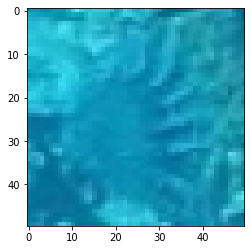

In [11]:
img, lab = train_ds[12]
print(lab)
plt.imshow(img.permute(2,1,0))

In [12]:
train_dl = DataLoader(dataset = train_ds, batch_size = batch_size, shuffle=True, num_workers=4)
val_dl = DataLoader(dataset = val_ds, batch_size = batch_size, shuffle=True, num_workers=4)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# get image norm values:

In [13]:
# mean=[0.485, 0.456, 0.406],
# std=[0.229, 0.224, 0.225]

# norm_ds = cot_Dataset(df)
# norm_dl = DataLoader(dataset = norm_ds, batch_size = 1, shuffle=True, num_workers=4)

# transform = A.Compose([
#      ToTensorV2(p=1.0)
# ])

# mean_list = []
# std_list = []
# for i in tqdm(range(len(norm_ds))):
#     img = norm_ds[i][0]
    
#     transformed = transform(image=img)["image"] # shape [chn,height,width]
#     mean, std = transformed.mean([0,2]).tolist(), transformed.std([0,2]).tolist()
# #     print(transformed.mean([0,2]).shape)
# #     break
#     mean_list.append(mean)
#     std_list.append(std)
    
# # print mean and std
# print("mean and std before normalize:")
# print("Mean of the image:", np.mean(mean_list,axis=0))
# print("Std of the image:", np.mean(std_list,axis=0))

In [14]:
# size_set = set()
# for i,x in tqdm(df.iterrows()):
#     img_path = x.img_path
#     size_set.add(plt.imread(img_path).shape)
# print(size_set)

In [15]:
##To read it again from file
with open('../input/random-images-dataset/size_set.txt','rb') as f:
    my_set = pickle.load(f)
    
# print(my_set)

In [16]:
# Simple CNN
class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.fc1 = nn.Linear(2304, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [17]:
# import torchvision.models as models
# import torch.nn as nn
# def build_model(pretrained=True, fine_tune=True, num_classes=10):
#     if pretrained:
#         print('[INFO]: Loading pre-trained weights')
#     else:
#         print('[INFO]: Not loading pre-trained weights')
#     model = models.efficientnet_b0(pretrained=pretrained)
#     if fine_tune:
#         print('[INFO]: Fine-tuning all layers...')
#         for params in model.parameters():
#             params.requires_grad = True
#     elif not fine_tune:
#         print('[INFO]: Freezing hidden layers...')
#         for params in model.parameters():
#             params.requires_grad = False
#     # Change the final classification head.
#     model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
#     return model

In [18]:
# Initialize network
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
# model = build_model(
#         pretrained=True,
#         fine_tune=True, 
#         num_classes=len(dataset_classes)
#     ).to(device)
    
# # Total parameters and trainable parameters.
# total_params = sum(p.numel() for p in model.parameters())
# print(f"{total_params:,} total parameters.")
# total_trainable_params = sum(
#     p.numel() for p in model.parameters() if p.requires_grad)
# print(f"{total_trainable_params:,} training parameters.")
# # Optimizer.
# optimizer = optim.Adam(model.parameters(), lr=lr)
# # Loss function.
# criterion = nn.CrossEntropyLoss()

In [20]:
def calc_accuracy(true,pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 4)

In [21]:
def save_model(epoch, model, optimizer, path):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, path)

In [22]:
### Training Code

for epoch in range(num_epochs):
    print("#"*20 + f"  [{epoch+1}/{num_epochs}]  " + "#"*20)
    start = time.time()
    
    #Epoch Loss & Accuracy
    train_epoch_loss = []
    train_epoch_accuracy = []
    _iter = 1
    
    #Val Loss & Accuracy
    val_epoch_loss = []
    val_epoch_accuracy = []
    
    # Training
    for images, labels in train_dl:
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Reset Grads
        optimizer.zero_grad()
        
        #Forward ->
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
#         acc = check_accuracy(zip(images,labels.cpu()), model)
        
        #Calculate Loss & Backward, Update Weights (Step)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        
        #Append loss & acc
        loss_value = loss.item()
        train_epoch_loss.append(loss_value)
        train_epoch_accuracy.append(acc)
        
        if _iter % 500 == 0:
            print(f"> Iteration {_iter} <  | Iter Loss = {round(loss_value, 4)}  | Iter Accuracy = {acc} % \n")
            
#             print("> Iteration {} < ".format(_iter))
#             print("Iter Loss = {}".format(round(loss_value, 4)))
#             print("Iter Accuracy = {} % \n".format(acc))
        
        _iter += 1
    
    #Validation
    for images, labels in val_dl:
        
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward ->
        preds = model(images)
        
        #Calculate Accuracy
        acc = calc_accuracy(labels.cpu(), preds.cpu())
        
        #Calculate Loss
        loss = criterion(preds, labels)
        
        #Append loss & acc
        loss_value = loss.item()
        val_epoch_loss.append(loss_value)
        val_epoch_accuracy.append(acc)
    
    
    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    
    end = time.time()
    
#     train_loss.append(train_epoch_loss)
#     train_accuracy.append(train_epoch_accuracy)
    
#     val_loss.append(val_epoch_loss)
#     val_accuracy.append(val_epoch_accuracy)
    
    save_model(epoch, model, optimizer, f'cots_cnn_e{epoch}bs8.pt')
    
    #Print Epoch Statistics
    print(f"** Epoch {epoch+1}/{num_epochs} ** - Epoch Time {round((end-start)/60,4)} min  | Train Loss = {round(train_epoch_loss, 4)}  Train Accuracy = {train_epoch_accuracy} %  |  Val Loss = {round(val_epoch_loss, 4)}  |  Val Accuracy = {val_epoch_accuracy} % \n")
#     print("** Epoch {} ** - Epoch Time {}".format(epoch, int(end-start)))
#     print("Train Loss = {}".format(round(train_epoch_loss, 4)))
#     print("Train Accuracy = {} % \n".format(train_epoch_accuracy))
#     print("Val Loss = {}".format(round(val_epoch_loss, 4)))
#     print("Val Accuracy = {} % \n".format(val_epoch_accuracy))

####################  [1/20]  ####################
** Epoch 1/20 ** - Epoch Time 0.7256 min  | Train Loss = 0.466  Train Accuracy = 77.88970801603206 %  |  Val Loss = 0.3842  |  Val Accuracy = 82.29264390243904 % 

####################  [2/20]  ####################
** Epoch 2/20 ** - Epoch Time 0.2688 min  | Train Loss = 0.3123  Train Accuracy = 86.50425851703407 %  |  Val Loss = 0.2988  |  Val Accuracy = 87.18925894308943 % 

####################  [3/20]  ####################
** Epoch 3/20 ** - Epoch Time 0.2589 min  | Train Loss = 0.2392  Train Accuracy = 90.11415691382766 %  |  Val Loss = 0.2329  |  Val Accuracy = 90.51164796747969 % 

####################  [4/20]  ####################
** Epoch 4/20 ** - Epoch Time 0.2629 min  | Train Loss = 0.222  Train Accuracy = 91.01953907815631 %  |  Val Loss = 0.2115  |  Val Accuracy = 91.42041910569105 % 

####################  [5/20]  ####################
** Epoch 5/20 ** - Epoch Time 0.2642 min  | Train Loss = 0.2072  Train Accuracy = 91.58

In [23]:
# # Train Network
# model.train()
# train_loss = 0

# for epoch in range(num_epochs):
#     time_start = time.time()
#     loss_accum = 0
#     for batch_idx, (data, targets) in enumerate(tqdm(train_dl)):
#         # Get data to cuda if possible
#         data = data.to(device=device)
#         targets = targets.to(device=device)
# #         print(data.shape)
#         # forward
#         scores = model(data)
#         loss = criterion(scores, targets)
        
#         loss_value = loss.item()

#         loss_accum += loss_value
# #         train_loss += loss.item()
        
#         # backward
#         optimizer.zero_grad()
#         loss.backward()

#         # gradient descent or adam step
#         optimizer.step()
        
#         # Print metrics so we see some progress
# #         print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
# #         # return average loss for the epoch
# #         avg_loss = train_loss / (batch_idx+1)
# #         print('Training set: Average loss: {:.6f}'.format(avg_loss))

In [24]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return num_correct/num_samples


print(f"Accuracy on training set: {check_accuracy(train_dl, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(val_dl, model)*100:.2f}")

Accuracy on training set: 95.40
Accuracy on test set: 94.13
